In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
runner = pd.read_csv("../../../output/data_clean/cleaned_runner.csv", index_col=0)
race = pd.read_csv("../../../output/data_clean/cleaned_race_equivalent_distance.csv", index_col= 0)
runner.age_range = pd.Categorical(
    runner.age_range, categories=['16-25','26-40','40-60','61+','Undefined'],ordered=True
)
runner = runner.dropna()

## Pretraitement

In [4]:
race = race.assign(
    date = pd.to_datetime(race[['month', 'day', 'year']])
)
join = pd.merge(runner, race, left_on="race_year_id", right_on="race_year_id", how="left")
join = join.loc[join.age_range != "Undefined"]
join = join.assign(
    relative_ranking = join.ranking / join.frequency_in_ranking
)

In [5]:
join.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112176 entries, 0 to 112185
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   race_year_id          112176 non-null  int64         
 1   ranking               112176 non-null  float64       
 2   runner                112176 non-null  object        
 3   time                  112176 non-null  object        
 4   age                   112176 non-null  float64       
 5   gender                112176 non-null  object        
 6   nationality           112176 non-null  object        
 7   time_in_seconds       112176 non-null  float64       
 8   runner_id             112176 non-null  object        
 9   age_course            112176 non-null  float64       
 10  age_range             112176 non-null  category      
 11  speed                 112176 non-null  float64       
 12  equivalent_speed      112176 non-null  float64       
 13 

## Prédiction de performance pour les coureurs en 2019

In [10]:
def runner_profile(join, race, race_year_id_to_predict):
    #Collect data from course
    race_to_predict = race.loc[race.race_year_id == race_year_id_to_predict]
    race_year_id = race_to_predict.iloc[0]['race_year_id']
    date_to_predict = race_to_predict.iloc[0]['date']
    distance_to_predict = race_to_predict.iloc[0]['equivalent_distance']
    country_to_predict = race_to_predict.iloc[0]['country_code']
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join.loc[join.race_year_id == race_year_id]['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_info = join.loc[(join.runner_id == runner) & (join.date == date_to_predict)]
        runner_past = join.loc[(join.runner_id == runner) & (join.date < date_to_predict)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_info['age'].iloc[0]
        gender = runner_info['gender'].iloc[0]
        nationality = runner_info['nationality'].iloc[0]
        
        #Processed data
        total_races = 0
        avg_relative_rank = 1
        avg_rank = 10000
        max_relative_rank = 1
        min_relative_rank = 1
        
        total_elevation = 0
        avg_elevation = 0
        
        total_distance = 0
        avg_distance = 0
        min_distance = 0
        max_distance = 0
        
        total_eq_distance = 0
        avg_eq_distance = 0
        min_eq_distance = 0
        max_eq_distance = 0
        
        avg_runners = 0
        
        years_of_activity = race_to_predict.year
        last_year_activity = race_to_predict.year
        
        
        
        
        has_run = 0
        has_run_last_year = 0
        has_run_equivalent_course = 0
        avg_course_per_year = 0
        distance_previous_year = 0
        ranking_score = 0
        avg_speed = 0
        last_course_speed = 0
        home_country = 0
        avg_speed = 0
        avg_equivalent_speed = 0
        
        if nationality == country_to_predict:
            home_country = 1
        
        if runner_past.size >= 1: 
            has_run = 1
            total_races = runner_past.shape[0]
            
            avg_relative_rank = runner_past.relative_ranking.mean()
            avg_rank = runner_past.ranking.mean()
            max_relative_rank = runner_past.relative_ranking.max()
            min_relative_rank = runner_past.relative_ranking.min()
            
            total_elevation = runner_past.elevation_gain.sum()
            avg_elevation = runner_past.elevation_gain.mean()
            
            total_distance =  runner_past.distance.sum()
            avg_distance = runner_past.distance.mean()
            min_distance = runner_past.distance.min()
            max_distance = runner_past.distance.max()
            
            total_eq_distance = runner_past.equivalent_distance.sum()
            avg_eq_distance = runner_past.equivalent_distance.mean()
            min_eq_distance = runner_past.equivalent_distance.min()
            max_eq_distance = runner_past.equivalent_distance.max()
            
            avg_runners = runner_past.frequency_in_ranking.mean()

            avg_speed = runner_past.equivalent_speed.mean()
            last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']
            
            years_of_activity = race_to_predict.year - runner_past.year.min()
            
            last_year_activity = runner_past.year.max()
            
            
            avg_speed = runner_past.speed.mean()
            avg_equivalent_speed = runner_past.equivalent_speed.mean()
            
            
#             for i in range(len(runner_past)):
#                 ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

            if len(runner_past.loc[runner_past.equivalent_distance >= distance_to_predict -10 ]):
                has_run_equivalent_course = 1
            
            year_interval = runner_past.year.max()- runner_past.year.min()
            if year_interval != 0:
                avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'last_year_activity': last_year_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        
                        'total_distance': total_distance,
#                         'distance_previous_year': distance_previous_year,
                        'has_run': has_run,
#                         'has_run_last_year': has_run_last_year,
                        'has_run_equivalent_course': has_run_equivalent_course,
                        'avg_course_per_year': avg_course_per_year,
#                         'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                        'last_course_speed': last_course_speed,
                        'home_country': home_country
                       }, ignore_index = True)
        
        
    values_to_predict = join.loc[join.race_year_id == race_year_id_to_predict][['runner_id','ranking','relative_ranking','time_in_seconds']]
    values_to_predict = values_to_predict.drop_duplicates(subset=['runner_id'], keep='last')
    values_to_predict = values_to_predict.reset_index()
    
    #one_hot_gender = pd.get_dummies(df['gender'], prefix = "gender")
    #one_hot_nationality= pd.get_dummies(df['nationality'], prefix = "nat")
    # Drop column B as it is now encoded
    #df = df.drop('gender',axis = 1)
    #df = df.drop('nationality',axis = 1)
    # Join the encoded df
    #df = df.join(one_hot_gender)
    #df = df.join(one_hot_nationality)
    
    return df, values_to_predict

In [11]:
runner_p, dz = runner_profile(join,race, 39881)

100%|███████████████████████████████████████| 1557/1557 [00:18<00:00, 83.74it/s]


In [12]:
runner_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557 entries, 0 to 1556
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   runner_id                  1557 non-null   object 
 1   age                        1557 non-null   float64
 2   gender                     1557 non-null   object 
 3   nationality                1557 non-null   object 
 4   n_races                    1557 non-null   float64
 5   avg_relative_rank          1557 non-null   float64
 6   avg_rank                   1557 non-null   float64
 7   max_relative_rank          1557 non-null   float64
 8   min_relative_rank          1557 non-null   float64
 9   total_elevation            1557 non-null   float64
 10  avg_elevation              1557 non-null   float64
 11  total_distance             1557 non-null   float64
 12  avg_distance               1557 non-null   float64
 13  min_distance               1557 non-null   float

<AxesSubplot:>

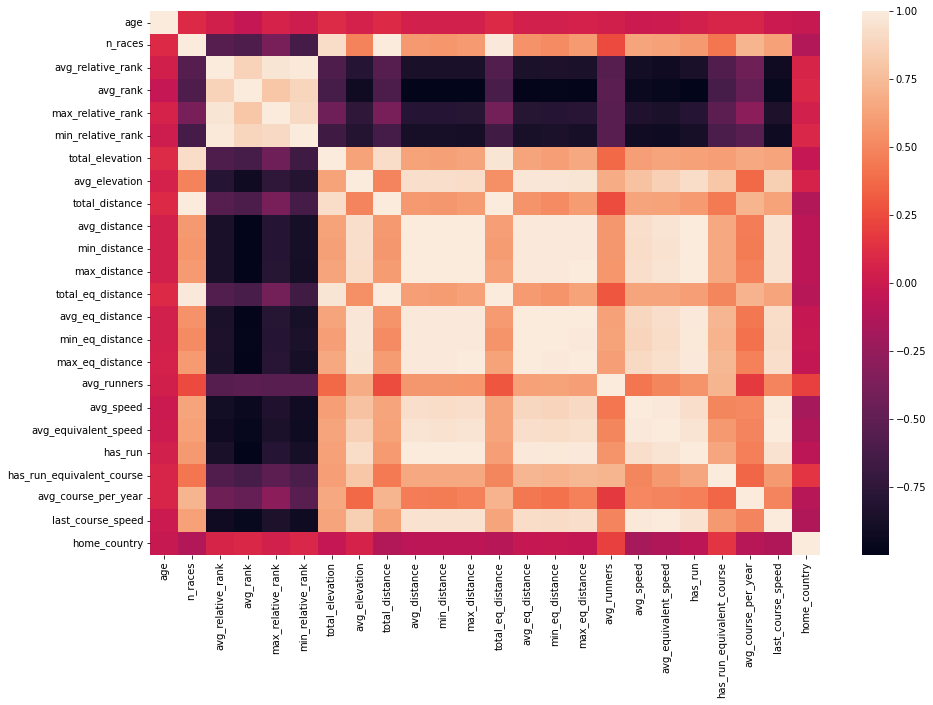

In [13]:
plt.figure(figsize=(15,10))
sns.heatmap(runner_p.corr(), annot=False)

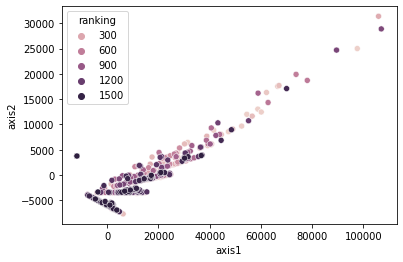

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = runner_p.drop(columns=['runner_id','gender','nationality'])

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
X['ranking'] = dz.ranking
X['relative_ranking'] = dz.relative_ranking

sns.scatterplot(x = "axis1", y = "axis2", hue="ranking",data = X)
plt.savefig('test1.pdf')


In [16]:
cls.explained_variance_ratio_

array([8.97455120e-01, 9.33796241e-02, 7.92228131e-03, 1.18078555e-03,
       5.45257540e-05])

In [17]:
cls.components_

array([[ 5.34780188e-05,  1.18256130e-04, -1.58302122e-05,
        -2.28731664e-01, -1.17660262e-05, -1.88860401e-05,
         9.48371630e-01,  2.10091385e-01,  1.95022837e-02,
         3.89824706e-03,  3.79658857e-03,  3.99483509e-03,
         2.89860000e-02,  5.99916091e-03,  5.62057032e-03,
         6.38513426e-03,  2.26413268e-02, -4.74079496e-02,
        -2.74338186e-05,  1.16737539e-04,  1.77047239e-04,
         2.35336507e-05,  2.08197528e-05,  3.58694523e-05,
         1.78324189e-04, -1.06559901e-06],
       [ 7.11036389e-05,  5.87945143e-05,  4.24326041e-05,
         6.93726891e-01,  4.53264908e-05,  4.12107356e-05,
         3.14839904e-01, -6.25790348e-01,  9.57437499e-03,
        -1.18868900e-02, -1.19305382e-02, -1.18413245e-02,
         1.27227740e-02, -1.81447935e-02, -1.83752569e-02,
        -1.78876305e-02, -7.29763492e-02,  1.44965174e-01,
         1.43674187e-04, -3.12536631e-04, -4.72161543e-04,
        -7.18400295e-05, -3.73747193e-05,  8.82609722e-06,
        -4.72

<AxesSubplot:xlabel='time_in_seconds', ylabel='Count'>

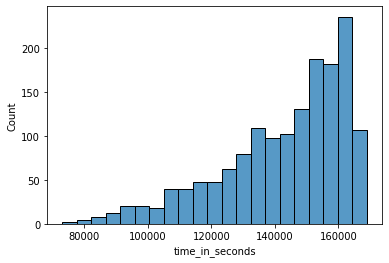

In [13]:
sns.histplot(x = dz.time_in_seconds)

In [18]:
runner_p

,runner_id,age,gender,nationality,n_races,avg_relative_rank,avg_rank,max_relative_rank,min_relative_rank,total_elevation,...,avg_runners,years_of_activity,last_year_activity,avg_speed,avg_equivalent_speed,has_run,has_run_equivalent_course,avg_course_per_year,last_course_speed,home_country
0,CAPELLPauESPM30.0,30.0,M,ESP,3.0,0.002780,3.000000,0.004630,0.001351,24780.0,...,1412.666667,"257 2 Name: year, dtype: int64",2019.0,8.405061,12.609136,1.0,1.0,1.500000,12.005744,0.0
1,THEVENARDXavierFRAM33.0,33.0,M,FRA,6.0,0.006824,1.833333,0.026786,0.000390,57633.0,...,1438.333333,"257 6 Name: year, dtype: int64",2019.0,7.997199,12.569568,1.0,1.0,1.000000,12.347491,1.0
2,HAWKERScottNZLM34.0,34.0,M,NZL,2.0,0.022378,37.500000,0.040430,0.004327,19598.0,...,2062.500000,"257 5 Name: year, dtype: int64",2017.0,6.850133,10.849617,1.0,1.0,0.666667,12.239097,0.0
3,OWENSTomGBRM40.0,40.0,M,GBR,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,...,0.000000,"257 2019 Name: year, dtype: int64","257 2019 Name: year, dtype: int64",0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
4,SYMONDSAndyGBRM40.0,40.0,M,GBR,1.0,0.006294,16.000000,0.006294,0.006294,9980.0,...,2542.000000,"257 2 Name: year, dtype: int64",2017,7.457244,11.871437,1.0,1.0,0.000000,11.871437,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1552,CHUILokNinJoeHKGM42.0,42.0,M,HKG,2.0,0.723176,470.000000,0.870000,0.576351,15490.0,...,790.000000,"257 2 Name: year, dtype: int64",2018,3.733797,5.492483,1.0,0.0,2.000000,5.510851,0.0
1553,TSEHonShingHKGM62.0,62.0,M,HKG,0.0,1.000000,10000.000000,1.000000,1.000000,0.0,...,0.000000,"257 2019 Name: year, dtype: int64","257 2019 Name: year, dtype: int64",0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1554,CLEMOTChristopheFRAM52.0,52.0,M,FRA,3.0,0.570148,1098.000000,0.625492,0.490411,26330.0,...,1824.000000,"257 2 Name: year, dtype: int64",2019,4.033878,6.081831,1.0,1.0,1.500000,6.360145,1.0
1555,LOPEZHIDALGORafaelESPM43.0,43.0,M,ESP,4.0,0.527057,947.250000,0.934795,0.348536,39738.0,...,1832.750000,"257 6 Name: year, dtype: int64",2017,4.071517,6.463236,1.0,1.0,1.000000,6.407002,0.0


In [19]:
runner_p_quant = runner_p.drop(columns=['runner_id','gender','nationality'])
runner_p_quant.years_of_activity = runner_p_quant.years_of_activity.astype(int)
runner_p_quant.last_year_activity = runner_p_quant.last_year_activity.astype(int)
runner_p_quant = runner_p_quant.iloc[:,:28]
runner_p_quant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1557 entries, 0 to 1556
Data columns (total 26 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        1557 non-null   float64
 1   n_races                    1557 non-null   float64
 2   avg_relative_rank          1557 non-null   float64
 3   avg_rank                   1557 non-null   float64
 4   max_relative_rank          1557 non-null   float64
 5   min_relative_rank          1557 non-null   float64
 6   total_elevation            1557 non-null   float64
 7   avg_elevation              1557 non-null   float64
 8   total_distance             1557 non-null   float64
 9   avg_distance               1557 non-null   float64
 10  min_distance               1557 non-null   float64
 11  max_distance               1557 non-null   float64
 12  total_eq_distance          1557 non-null   float64
 13  avg_eq_distance            1557 non-null   float

In [20]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(runner_p_quant)),
    columns = runner_p.runner_id,
    index = runner_p.runner_id
)

In [2]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

In [22]:
mds_Xprime = MDS(n_components=2, dissimilarity='precomputed')
aftd_Xprime = mds_Xprime.fit_transform(X)

<AxesSubplot:xlabel='axis1', ylabel='axis2'>

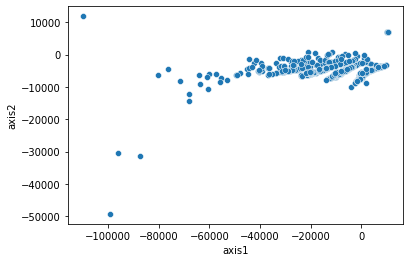

In [24]:
new_Xprime = pd.DataFrame(aftd_Xprime, columns=["axis1","axis2"])
sns.scatterplot(
    x = "axis1",
    y = "axis2",
    data = new_Xprime
)

In [25]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    default_kwargs = dict(leaf_font_size=10)
    default_kwargs.update(kwargs or {})

    dendrogram(linkage_matrix, **default_kwargs)


In [26]:
cls = AgglomerativeClustering(linkage="ward", affinity="euclidean", distance_threshold=0, n_clusters=None)
cls.fit(df)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

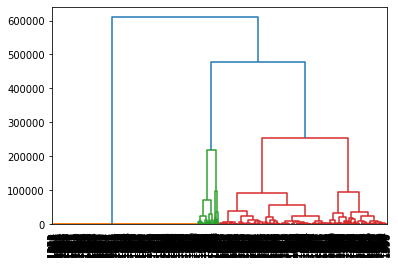

In [27]:
plot_dendrogram(cls)

/home/romain/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NameError: name 'add_labels' is not defined

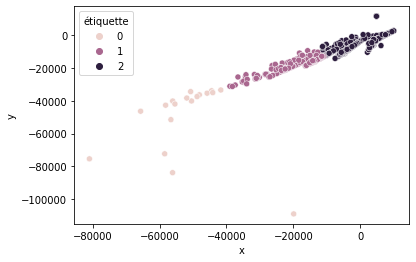

In [36]:
model = AgglomerativeClustering(
    affinity="precomputed", linkage="complete", n_clusters=3
).fit(X)

labels = model.labels_

aftd = MDS(n_components=2, dissimilarity="precomputed")
dist = aftd.fit_transform(X)

new_df = pd.DataFrame({"x": dist[:, 0], "y": dist[:, 1], "étiquette": labels})

sns.scatterplot("x", "y", hue="étiquette", data=new_df)
add_labels(dist[:, 0], dist[:, 1], X.index)
plt.show()

In [31]:
runner_p = runner_p.assign( label = labels)

<AxesSubplot:>

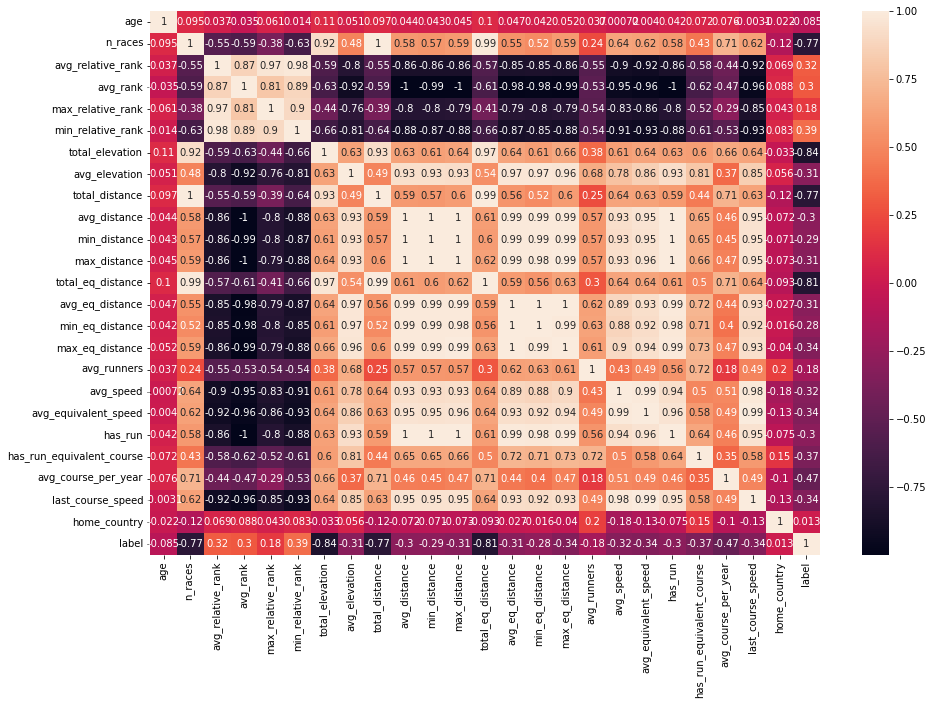

In [33]:
plt.figure(figsize=(15,10))
sns.heatmap(runner_p.corr(), annot=True)

# Test d'apprentissage KPPV

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy.linalg as linalg
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.linalg as linalg
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import dendrogram
import math
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [42]:
Z = dz
X = runner_p.drop(columns=['runner_id','gender','nationality'])

In [43]:
def model_efficiency(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    for q in tqdm(np.arange(0.05,1,0.05)):
#         time_TH = Z.time_in_seconds.quantile(q)
#         Z = Z.assign( flag = Z.time_in_seconds > time_TH )
#         y = Z['flag'].astype(int)
#         df['quantile'] = pd.qcut(df['b'], 2, labels=False)
        
        y = pd.qcut(Z['time_in_seconds'], 2, labels=False)
       
        
        res_GS = clf.fit(X,y)

        ### PLOT PARAM test_score
        #sns.lineplot(
        #    x ='param_n_neighbors', 
        #    y = 'mean_test_score', 
        #    data = res_GS.cv_results_
        #)
        cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
        cls.fit(X,y)
        labels = cls.predict(X)
    
    
        res.append((q,accuracy_score(y, labels)))
    return res

In [44]:
def model_efficiency2(X,Z):
    res = []
    param_grid ={
        'n_neighbors' : [a for a in range(2,50)]
    }
    estimator = KNeighborsClassifier()
    clf = GridSearchCV(estimator, param_grid)

    y = pd.qcut(Z['relative_ranking'], 10, labels=False)


    res_GS = clf.fit(X,y)

    ## PLOT PARAM test_score
    sns.lineplot(
       x ='param_n_neighbors', 
       y = 'mean_test_score', 
       data = res_GS.cv_results_
    )
    
    cls = KNeighborsClassifier(n_neighbors=res_GS.best_params_['n_neighbors'])
    cls.fit(X,y)
    labels = cls.predict(X)


    return accuracy_score(y, labels), labels


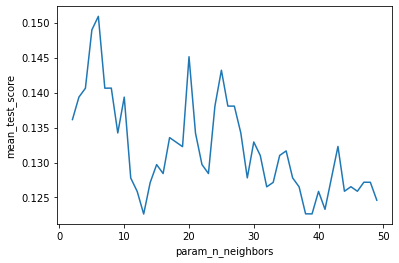

In [45]:
res, labels = model_efficiency2(X,Z)

In [46]:
res

0.3134232498394348

# Multiple Regression

In [4]:
from sklearn import linear_model 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression

In [48]:
y = Z['relative_ranking']

In [64]:
y = Z.time_in_seconds
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
LR = LinearRegression()
# LR = linear_model.Ridge(alpha=0.5)
# LR = linear_model.Lasso(alpha=0.1, max_iter=1000000)
# LR = linear_model.LassoLars(alpha=.1, normalize=False)
# LR = ElasticNet(random_state=0, max_iter=1000000)
LR.fit(x_train,y_train)
y_prediction =  LR.predict(x_test)
score=r2_score(y_test,y_prediction)
print('r2 socre is ',score)

r2 socre is  0.4864349023576584


In [65]:
verify = pd.DataFrame({"real":y_test, "pred":y_prediction})

<AxesSubplot:xlabel='real', ylabel='pred'>

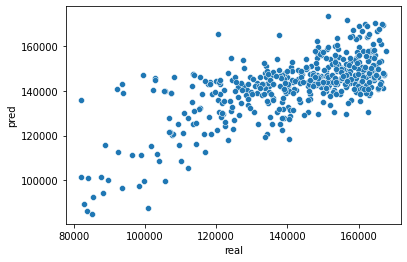

In [66]:
sns.scatterplot(
    x = "real",
    y = "pred",
    data = verify
)

<AxesSubplot:xlabel='relative_ranking', ylabel='Count'>

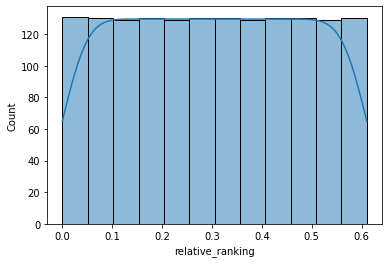

In [51]:
sns.histplot(x = dz.relative_ranking, kde=True)

<AxesSubplot:ylabel='Count'>

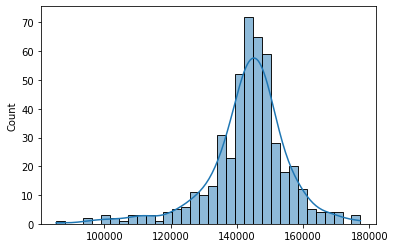

In [272]:
sns.histplot(x = y_prediction, kde=True)

In [67]:
y = pd.qcut(Z['time_in_seconds'], 10, labels=False)

In [68]:
from sklearn.model_selection import KFold, cross_val_score
def knn_cross_validation(X, y, n_folds, n_neighbors_list):
    # Générer la même sortie de `knn_cross_validation` en utilisant `cross_val_score`
    for n_neighbors in n_neighbors_list:
        cls = KNeighborsClassifier(n_neighbors=n_neighbors)
        for i in cross_val_score(cls, X, y, cv = n_folds):
            yield n_neighbors, i

<AxesSubplot:xlabel='n_neighbors', ylabel='accuracy'>

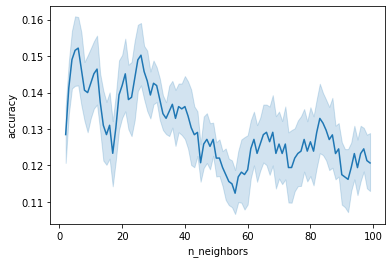

In [69]:
gen3 = knn_cross_validation(X, y,10, [i for i in range(2,100)])
df3 = pd.DataFrame(gen3, columns=["n_neighbors", "accuracy"])
sns.lineplot(
    x = 'n_neighbors',
    y = 'accuracy',
    data = df3,
    err_style="band", 
    ci=68
)

In [70]:
df3[df3.index == df3.idxmax().accuracy]

,n_neighbors,accuracy
225,24,0.217949


# Get all runners historic

In [71]:
def all_runner_profile(join):
    #Collect data from course
    #Return df
    df = pd.DataFrame()
    
    unique_runners = join['runner_id'].unique()
    for runner in tqdm(unique_runners):
        runner_past = join.loc[(join.runner_id == runner)]
        
        # Data processing
        #General data
        runner_id =  runner
        age = runner_past['age'].iloc[0]
        gender = runner_past['gender'].iloc[0]
        nationality = runner_past['nationality'].iloc[0]
        
        #Processed data        
        
        total_races = runner_past.shape[0]

        avg_relative_rank = runner_past.relative_ranking.mean()
        avg_rank = runner_past.ranking.mean()
        max_relative_rank = runner_past.relative_ranking.max()
        min_relative_rank = runner_past.relative_ranking.min()

        total_elevation = runner_past.elevation_gain.sum()
        avg_elevation = runner_past.elevation_gain.mean()

        total_distance =  runner_past.distance.sum()
        avg_distance = runner_past.distance.mean()
        min_distance = runner_past.distance.min()
        max_distance = runner_past.distance.max()

        total_eq_distance = runner_past.equivalent_distance.sum()
        avg_eq_distance = runner_past.equivalent_distance.mean()
        min_eq_distance = runner_past.equivalent_distance.min()
        max_eq_distance = runner_past.equivalent_distance.max()

        avg_runners = runner_past.frequency_in_ranking.mean()

        avg_speed = runner_past.equivalent_speed.mean()
        last_course_speed = runner_past.loc[runner_past.date.idxmax(),'equivalent_speed']

        years_of_activity = runner_past.year.max() - runner_past.year.min()

        last_year_activity = runner_past.year.max()


        avg_speed = runner_past.speed.mean()
        avg_equivalent_speed = runner_past.equivalent_speed.mean()

        ranking_score = 0
        for i in range(len(runner_past)):
            ranking_score += (1 / runner_past.iloc[i,1]) * np.log(runner_past.iloc[i,23] - 2010) 

        year_interval = runner_past.year.max()- runner_past.year.min()
        avg_course_per_year = 0
        if year_interval != 0:
            avg_course_per_year = total_races / year_interval
            
            
            
        df = df.append({'runner_id': runner_id, 
                        'age': age, 
                        'gender': gender, 
                        'nationality':nationality,
                        'n_races': total_races,
                        'avg_relative_rank': avg_relative_rank,
                        'avg_rank': avg_rank,
                        'max_relative_rank' : max_relative_rank,
                        'min_relative_rank' : min_relative_rank,
                        'total_elevation' : total_elevation,
                        'avg_elevation' : avg_elevation,
                        'total_distance' : total_distance,
                        'avg_distance' : avg_distance,
                        'min_distance' : min_distance,
                        'max_distance' : max_distance,
                        'total_eq_distance' : total_eq_distance,
                        'avg_eq_distance' : avg_eq_distance,
                        'min_eq_distance' : min_eq_distance,
                        'max_eq_distance' : max_eq_distance,
                        'avg_runners' : avg_runners,
                        'years_of_activity': years_of_activity,
                        'avg_speed': avg_speed,
                        'avg_equivalent_speed': avg_equivalent_speed,
                        'total_distance': total_distance,
                        'avg_course_per_year': avg_course_per_year,
                        'ranking_score': ranking_score,
                        'avg_speed': avg_speed,
                       }, ignore_index = True)
    
    return df

In [304]:
runner_data = all_runner_profile(join)

100%|████████████████████████████████████| 64193/64193 [09:33<00:00, 111.93it/s]


In [305]:
from pathlib import Path  

filepath = Path('../../output/data_clean/runner_data.csv')  

filepath.parent.mkdir(parents=True, exist_ok=True)  

runner_data.to_csv(filepath)  

In [5]:
all_runners = pd.read_csv('../../output/data_clean/runner_data.csv', index_col=0)

<AxesSubplot:xlabel='count', ylabel='n_races'>

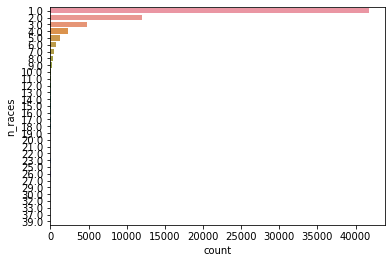

In [6]:
sns.countplot(
    y = all_runners.n_races
)

<AxesSubplot:xlabel='total_distance', ylabel='Count'>

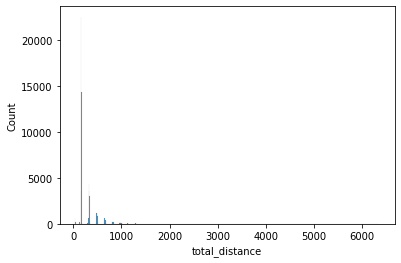

In [311]:
sns.histplot(
    x = runner_data.total_distance
)

Index(['age', 'n_races', 'avg_relative_rank', 'avg_rank', 'max_relative_rank',
       'min_relative_rank', 'total_elevation', 'avg_elevation',
       'total_distance', 'avg_distance', 'min_distance', 'max_distance',
       'total_eq_distance', 'avg_eq_distance', 'min_eq_distance',
       'max_eq_distance', 'avg_runners', 'years_of_activity', 'avg_speed',
       'avg_equivalent_speed', 'avg_course_per_year', 'ranking_score'],
      dtype='object')


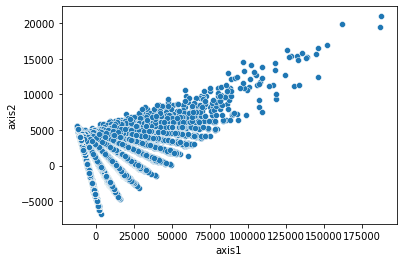

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = all_runners.drop(columns=['runner_id','gender','nationality'])
print(df.columns)

cls = PCA(n_components=5)
pcs = cls.fit_transform(df)

X = pd.DataFrame(pcs, columns=["axis1", "axis2","axis3","axis4","axis5"])
X.index = df.index
sns.scatterplot(x = "axis1", y = "axis2",data = X)
plt.savefig('../../../output/ACP_all_runners.pdf')


In [8]:
cls.explained_variance_ratio_

array([9.37986521e-01, 5.78983628e-02, 3.57941034e-03, 3.84603903e-04,
       1.39917578e-04])

In [14]:
runner_3plus = all_runners.loc[all_runners.n_races >3]
df = runner_3plus.drop(columns=['gender','nationality','runner_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5507 entries, 4 to 62446
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   5507 non-null   float64
 1   n_races               5507 non-null   float64
 2   avg_relative_rank     5507 non-null   float64
 3   avg_rank              5507 non-null   float64
 4   max_relative_rank     5507 non-null   float64
 5   min_relative_rank     5507 non-null   float64
 6   total_elevation       5507 non-null   float64
 7   avg_elevation         5507 non-null   float64
 8   total_distance        5507 non-null   float64
 9   avg_distance          5507 non-null   float64
 10  min_distance          5507 non-null   float64
 11  max_distance          5507 non-null   float64
 12  total_eq_distance     5507 non-null   float64
 13  avg_eq_distance       5507 non-null   float64
 14  min_eq_distance       5507 non-null   float64
 15  max_eq_distance     

In [15]:
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
X = pd.DataFrame(
    squareform(pdist(df)),
    columns = runner_3plus.runner_id,
    index = runner_3plus.runner_id
)

In [1]:
mds = MDS(n_components=2, dissimilarity='precomputed')
aftd = mds.fit_transform(X)

NameError: name 'MDS' is not defined

In [ ]:
new_Xprime = pd.DataFrame(aftd_Xprime, columns=["axis1","axis2"])
sns.scatterplot(
    x = "axis1",
    y = "axis2",
    data = new_Xprime
)